In [1]:
from gentropy.common.session import Session


app_name = "example_app"
CREDENTIALS = "/Users/xg1/.config/gcloud/service_account_credentials.json"

# GCS Connector configuration
GCS_CONNECTOR_CONF = {
    "spark.hadoop.fs.gs.impl": "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem",
    "spark.jars": "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar",
    "spark.hadoop.google.cloud.auth.service.account.enable": "true",
    "spark.hadoop.google.cloud.auth.service.account.json.keyfile": CREDENTIALS,
    "spark.hadoop.fs.gs.requester.pays.mode": "AUTO",  # Change to CUSTOM, ENABLED, or DISABLED as needed
    "spark.hadoop.fs.gs.requester.pays.project.id": "open-targets-genetics-dev", 
}

# Extended Spark configuration
extended_spark_conf = {
    "spark.driver.memory": "12g",
    "spark.kryoserializer.buffer.max": "500m",
    "spark.driver.maxResultSize": "3g",
}

# Combine configurations
combined_conf = {**GCS_CONNECTOR_CONF, **extended_spark_conf}

# Start the session
session = Session(
    spark_uri="local[*]",  # Use appropriate URI if needed
    app_name=app_name,
    extended_spark_conf=combined_conf
)

Loading BokehJS ...

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/06/30 09:53:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/30 09:53:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [12]:
from pyspark.sql import functions as f

study_index_path="gs://genetics-portal-dev-analysis/dc16/output/gentropy_paper/gwas_therapeutic_areas"
study_index_df = session.spark.read.parquet(study_index_path)

# Update publicationDate and publicationTitle for Finngen studies.
study_index_df = study_index_df.withColumn(
    "publicationDate",
    f.when(f.col("projectId") == "FINNGEN_R12", f.lit("2024-11-04"))
     .otherwise(f.col("publicationDate"))
).withColumn(
    "publicationTitle",
    f.when(f.col("projectId") == "FINNGEN_R12", f.lit("FinnGen provides genetic insights from a well-phenotyped isolated population."))
     .otherwise(f.col("publicationTitle"))
)

study_index_df.filter(f.col("projectId") == "FINNGEN_R12").show(truncate=False)

+--------------------------------------------------------+------+-----------+---------+-------------------------------------------------------------------------------------------------+----------------------------+---------------------+--------+-----------------------------------------------------------------------------+----------------------+---------------+------------------+----------------------------------+-------------------------------------------+------+---------+--------+---------+---------------------+-------------------+------------------+---------------+-------------+------------------------------------------------------------------------------------------------------+-----------+---------+---------------+----------------------------+--------------------+-----------+---------------------------+-----------+---------------+-------------------+-----------------+---------------------------+----------------------+---------------------+---------------+-----------------------+---

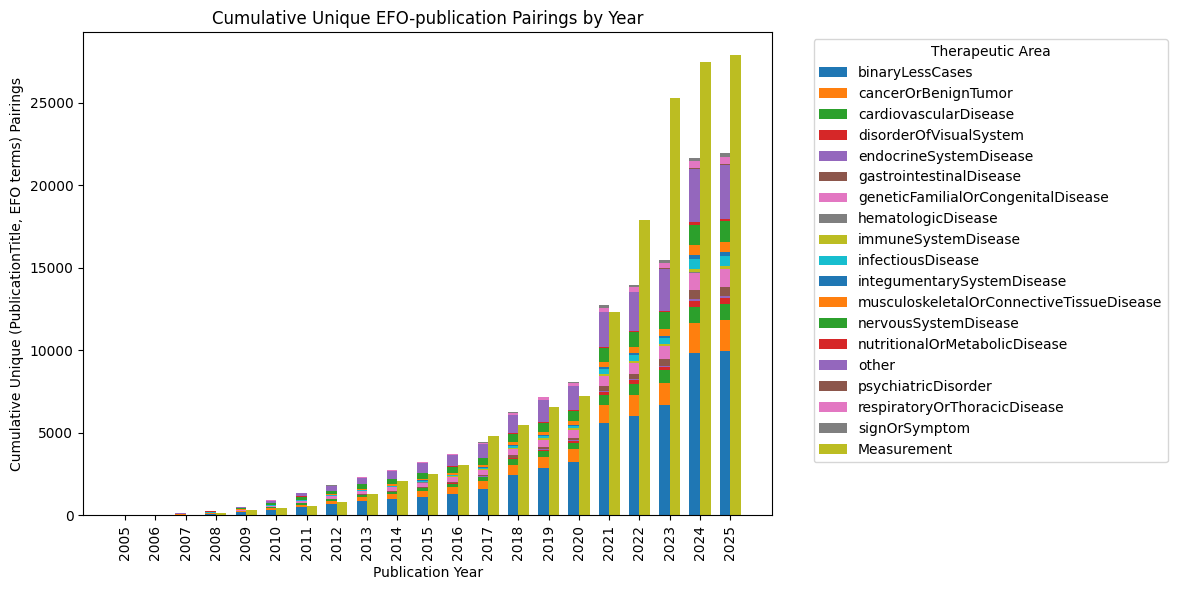

In [ ]:
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import numpy as np

# Parse publicationDate into a date and extract publicationYear.

study_index_df = study_index_df.withColumn("publicationDate", f.to_date(f.col("publicationDate"), "yyyy-MM-dd"))
study_index_df = study_index_df.withColumn("publicationYear", f.year(f.col("publicationDate")))

study_index_df = study_index_df.filter(
    f.col("publicationYear").isNotNull() &
    f.col("publicationTitle").isNotNull()
)

#  Create a sorted version of the diseaseIds array and convert it to a string.
#  This is to ensure that the same diseaseIds array in different orders is treated as the same.

study_index_df = study_index_df.withColumn("sortedDiseaseIds", f.sort_array("diseaseIds"))
study_index_df = study_index_df.withColumn("diseaseIds_str", f.concat_ws(",", f.col("sortedDiseaseIds")))


therapeutic_area_cols = [
    "hematologicDisease",
    "nutritionalOrMetabolicDisease",
    "geneticFamilialOrCongenitalDisease",
    "signOrSymptom",
    "nervousSystemDisease",
    "immuneSystemDisease",
    "psychiatricDisorder",
    "integumentarySystemDisease",
    "disorderOfVisualSystem",
    "cardiovascularDisease",
    "cancerOrBenignTumor",
    "respiratoryOrThoracicDisease",
    "gastrointestinalDisease",
    "endocrineSystemDisease",
    "musculoskeletalOrConnectiveTissueDisease",
    "infectiousDisease",
    "measurement",
    "binaryLessCases",
    "other"
]

study_index_df = study_index_df.withColumn(
    "publicationYear",
    f.when(f.col("publicationYear").isNotNull(), f.col("publicationYear"))
     .otherwise(f.year(f.to_date(f.col("publicationDate"), "yyyy-MM-dd")))
)

# Filter out missing values
study_index_df = study_index_df.filter(
    f.col("publicationYear").isNotNull() &
    f.col("publicationTitle").isNotNull()
)

study_index_df = study_index_df.withColumn("sortedDiseaseIds", f.sort_array("diseaseIds"))
study_index_df = study_index_df.withColumn("diseaseIds_str", f.concat_ws(",", f.col("sortedDiseaseIds")))

# Create therapeuticAreas array using updated column names
study_index_df = study_index_df.withColumn(
    "therapeuticAreas",
    f.array(*[f.when(f.col(col) == 1, f.lit(col)).otherwise(f.lit(None)) for col in therapeutic_area_cols])
)
study_index_df = study_index_df.withColumn(
    "therapeuticAreas",
    f.expr("filter(therapeuticAreas, x -> x is not null)")
)

study_index_exploded = study_index_df.withColumn("therapeuticArea", f.explode("therapeuticAreas"))

pair_counts_by_area = study_index_exploded.groupBy("publicationYear", "therapeuticArea") \
    .agg(f.countDistinct("publicationTitle", "diseaseIds_str").alias("unique_pairs")) \
    .orderBy("publicationYear")

# Pivot for plotting
pivot_df = pair_counts_by_area.groupBy("publicationYear") \
    .pivot("therapeuticArea") \
    .sum("unique_pairs") \
    .fillna(0) \
    .orderBy("publicationYear")

# To pandas for plotting
pair_counts_pd = pivot_df.toPandas()
pair_counts_pd['publicationYear'] = pair_counts_pd['publicationYear'].astype(int)
pair_counts_pd = pair_counts_pd.sort_values("publicationYear")
years = pair_counts_pd['publicationYear'].tolist()

# split out measurement
all_area_columns = [col for col in pair_counts_pd.columns if col != "publicationYear"]
non_measurement_cols = [col for col in all_area_columns if col not in ["measurement", "Measurement"]]
measurement_cols = ["measurement"] if "measurement" in all_area_columns else []

for col in non_measurement_cols + measurement_cols:
    pair_counts_pd[col] = pair_counts_pd[col].cumsum()

# Plot
x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Non-measurement stacked bar
bottom = np.zeros(len(years))
for cat in non_measurement_cols:
    ax.bar(x - width/2, pair_counts_pd[cat], width, bottom=bottom, label=cat)
    bottom += pair_counts_pd[cat].values

# Measurement bar separate
if measurement_cols:
    ax.bar(x + width/2, pair_counts_pd["measurement"], width, label="Measurement")

ax.set_xticks(x)
ax.set_xticklabels([str(year) for year in years], rotation=90)
ax.set_xlabel("Publication Year")
ax.set_ylabel("Cumulative Unique (PublicationTitle, EFO terms) Pairings")
ax.set_title("Cumulative Unique EFO-publication Pairings by Year")
ax.legend(title="Therapeutic Area", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [14]:
from gentropy.dataset.l2g_prediction import L2GPrediction
locus_to_gene_prediction_path="gs://open-targets-data-releases/25.06/output/l2g_prediction"
locus_to_gene_prediction = L2GPrediction.from_parquet(session, locus_to_gene_prediction_path)
# "gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/list_of_prioritised_genes_per_CS.parquet"

l2g_prioritised_genes_path = "gs://genetics-portal-dev-analysis/yt4/20250403_for_gentropy_paper/list_of_prioritised_genes_per_CS.parquet"
l2g_prioritised_genes_df = session.spark.read.parquet(l2g_prioritised_genes_path).drop("score")

locus_to_gene_prediction_df=l2g_prioritised_genes_df.join(locus_to_gene_prediction.df, on=["studyLocusId", "geneId"], how="inner")

from gentropy.dataset.study_locus import StudyLocus
credible_set_path = "gs://open-targets-data-releases/25.06/output/credible_set"
credible_set = StudyLocus.from_parquet(session, credible_set_path)

#join credible_set to locus_to_gene_prediction on studyLocusId:
locus_to_gene_prediction_df = locus_to_gene_prediction_df.join(credible_set.df.select("studyLocusId", "studyId", "variantId", "pValueMantissa", "pValueExponent"), "studyLocusId", "left")

# join to study_index on studyId
locus_to_gene_prediction_df = locus_to_gene_prediction_df.join(
    study_index_df.select(
        "studyId",
        "publicationDate",
        "publicationYear",
        "diseaseIds",
        "hematologicDisease",
        "nutritionalOrMetabolicDisease",
        "geneticFamilialOrCongenitalDisease",
        "signOrSymptom",
        "nervousSystemDisease",
        "immuneSystemDisease",
        "psychiatricDisorder",
        "integumentarySystemDisease",
        "disorderOfVisualSystem",
        "cardiovascularDisease",
        "cancerOrBenignTumor",
        "respiratoryOrThoracicDisease",
        "gastrointestinalDisease",
        "endocrineSystemDisease",
        "musculoskeletalOrConnectiveTissueDisease",
        "infectiousDisease",
        "measurement",
        "binaryLessCases",
        "other"
    ),
    "studyId",
    "left"
)

locus_to_gene_prediction_df.printSchema()

root
 |-- studyId: string (nullable = true)
 |-- studyLocusId: string (nullable = true)
 |-- geneId: string (nullable = true)
 |-- eQTL_coloc: integer (nullable = true)
 |-- pQTL_coloc: integer (nullable = true)
 |-- VEP: integer (nullable = true)
 |-- distanceTSS: integer (nullable = true)
 |-- score: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- value: float (nullable = true)
 |    |    |-- shapValue: float (nullable = true)
 |-- shapBaseValue: float (nullable = true)
 |-- variantId: string (nullable = true)
 |-- pValueMantissa: float (nullable = true)
 |-- pValueExponent: integer (nullable = true)
 |-- publicationDate: date (nullable = true)
 |-- publicationYear: integer (nullable = true)
 |-- diseaseIds: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hematologicDisease: integer (nullable = true)
 |-- nutritionalOrMetabolicDisea

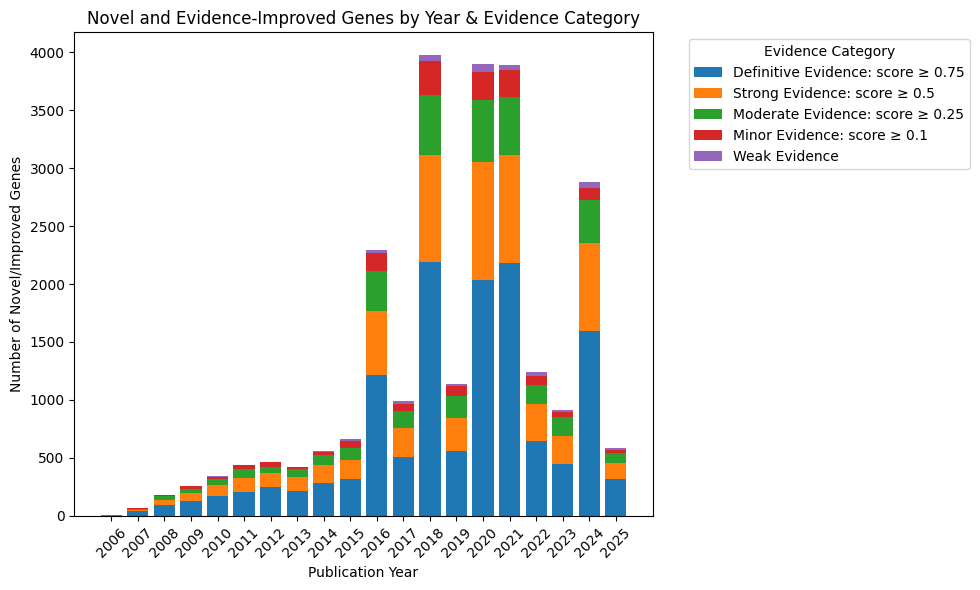

25/06/30 10:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:52:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/06/30 10:52:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:52:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/06/30 10:52:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:52:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/06/30 10:53:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:53:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/06/30 10:53:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:53:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/06/30 10:53:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:53:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


25/06/30 10:53:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:53:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:53:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:53:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:53:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 10:53:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/06/30 1

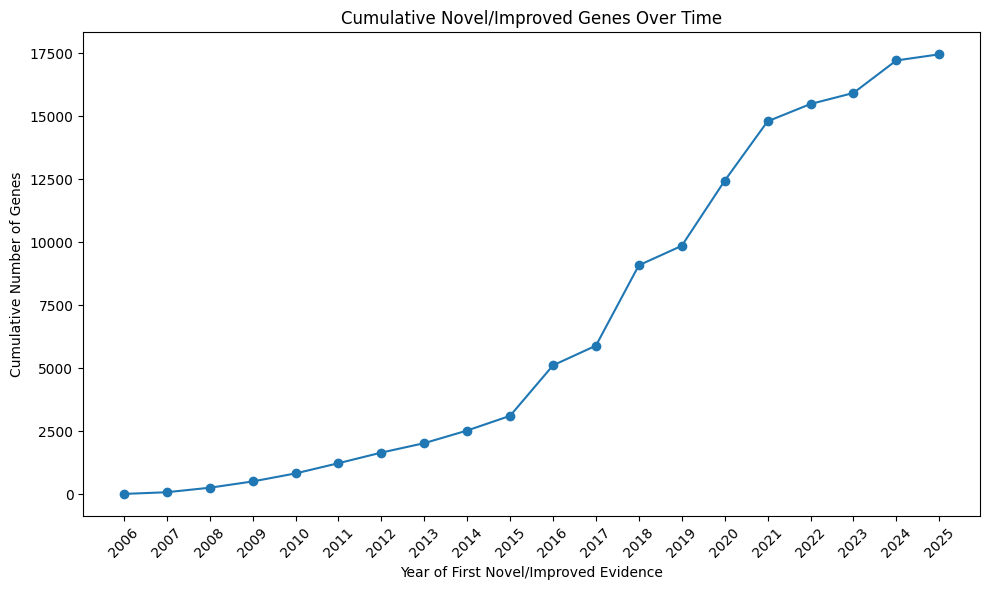

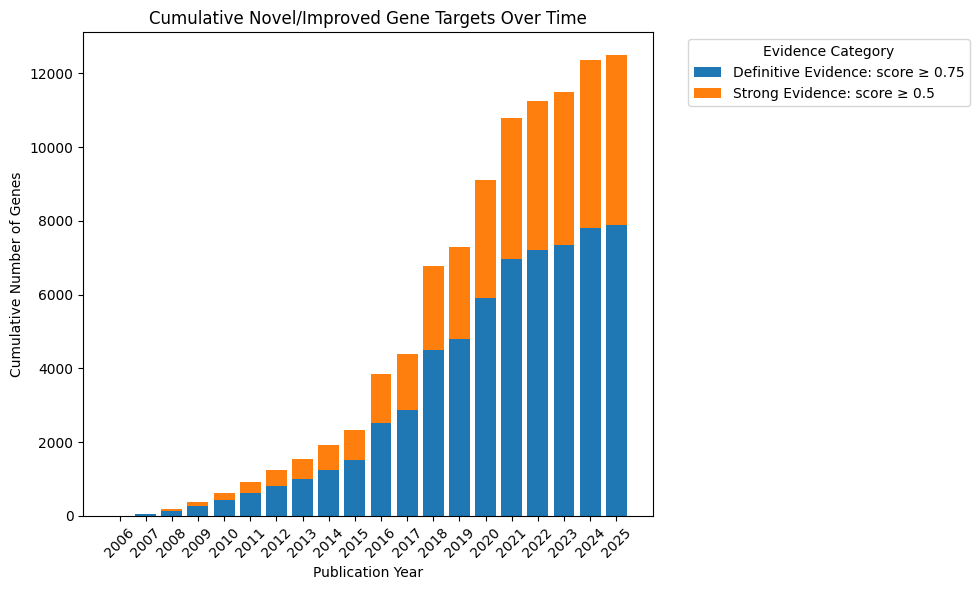

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

import pyspark.sql.functions as f
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Annotate with evidence category and evidence_rank.
# -----------------------------------------------------------------------------
df_with_score = locus_to_gene_prediction_df.withColumn(
    "score_category",
    f.when(f.col("score") >= 0.75, "Definitive Evidence: score ≥ 0.75")
     .when(f.col("score") >= 0.5, "Strong Evidence: score ≥ 0.5")
     .when(f.col("score") >= 0.25, "Moderate Evidence: score ≥ 0.25")
     .when(f.col("score") >= 0.1, "Minor Evidence: score ≥ 0.1")
     .otherwise("Weak Evidence")
).withColumn(
    "evidence_rank",
    f.when(f.col("score") >= 0.75, 5)
     .when(f.col("score") >= 0.5, 4)
     .when(f.col("score") >= 0.25, 3)
     .when(f.col("score") >= 0.1, 2)
     .otherwise(1)
)

df_filtered = df_with_score.filter(
    f.col("publicationYear").isNotNull() &
    f.col("geneId").isNotNull()
)

# -----------------------------------------------------------------------------
# 3. Deduplicate to one record per gene-year, preserving highest evidence_rank.
# -----------------------------------------------------------------------------
# First, get max rank per geneId & publicationYear
gene_year = (
    df_filtered
    .groupBy("geneId", "publicationYear")
    .agg(f.max("evidence_rank").alias("max_rank"))
    .withColumn(
        "best_score_category",
        f.when(f.col("max_rank") == 5, "Definitive Evidence: score ≥ 0.75")
         .when(f.col("max_rank") == 4, "Strong Evidence: score ≥ 0.5")
         .when(f.col("max_rank") == 3, "Moderate Evidence: score ≥ 0.25")
         .when(f.col("max_rank") == 2, "Minor Evidence: score ≥ 0.1")
         .otherwise("Weak Evidence")
    )
)

# -----------------------------------------------------------------------------
# Identify novel or improved events per gene.
#    Compare each year's max_rank to the best seen in prior years for that gene.
# -----------------------------------------------------------------------------
w = Window.partitionBy("geneId").orderBy("publicationYear") \
          .rowsBetween(Window.unboundedPreceding, -1)
gene_year = gene_year.withColumn("prev_max_rank", f.max("max_rank").over(w))
gene_year = gene_year.withColumn(
    "is_event",
    f.when(
        f.col("prev_max_rank").isNull() | (f.col("max_rank") > f.col("prev_max_rank")),
        True
    ).otherwise(False)
)

# -----------------------------------------------------------------------------
# Filter to only those gene-year rows that are novel or improved.
# -----------------------------------------------------------------------------
events_df = gene_year.filter(f.col("is_event") == True)

# -----------------------------------------------------------------------------
# Count events by publicationYear and evidence category.
# -----------------------------------------------------------------------------
events_grouped = (
    events_df
    .groupBy("publicationYear", "best_score_category")
    .agg(f.count("*").alias("event_count"))
    .orderBy("publicationYear")
)

pivot_df = (
    events_grouped
    .groupBy("publicationYear")
    .pivot("best_score_category", [
        "Definitive Evidence: score ≥ 0.75",
        "Strong Evidence: score ≥ 0.5",
        "Moderate Evidence: score ≥ 0.25",
        "Minor Evidence: score ≥ 0.1",
        "Weak Evidence"
    ])
    .sum("event_count")
    .fillna(0)
    .orderBy("publicationYear")
)

pivot_pd = pivot_df.toPandas()
pivot_pd['publicationYear'] = pivot_pd['publicationYear'].astype(int).astype(str)
pivot_pd = pivot_pd.sort_values("publicationYear")

categories = [
    "Definitive Evidence: score ≥ 0.75",
    "Strong Evidence: score ≥ 0.5",
    "Moderate Evidence: score ≥ 0.25",
    "Minor Evidence: score ≥ 0.1",
    "Weak Evidence"
]
categories = [c for c in categories if c in pivot_pd.columns]

plt.figure(figsize=(10, 6))
bottom = None
for cat in categories:
    if bottom is None:
        plt.bar(pivot_pd["publicationYear"], pivot_pd[cat], label=cat)
        bottom = pivot_pd[cat].values
    else:
        plt.bar(pivot_pd["publicationYear"], pivot_pd[cat], bottom=bottom, label=cat)
        bottom = bottom + pivot_pd[cat].values

plt.xlabel("Publication Year")
plt.ylabel("Number of Novel/Improved Genes")
plt.title("Novel and Evidence-Improved Genes by Year & Evidence Category")
plt.xticks(rotation=45)
plt.legend(title="Evidence Category", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Separate plot: cumulative novel genes over years
# -----------------------------------------------------------------------------
first_event = (
    events_df
    .groupBy("geneId")
    .agg(f.min("publicationYear").alias("first_year"))
)

# Count new genes per year
new_genes_per_year = (
    first_event
    .groupBy("first_year")
    .count()
    .withColumnRenamed("count", "new_gene_count")
    .orderBy("first_year")
)

# Compute cumulative sum
w2 = Window.orderBy("first_year").rowsBetween(Window.unboundedPreceding, 0)
new_genes_per_year = new_genes_per_year.withColumn(
    "cumulative_genes",
    f.sum("new_gene_count").over(w2)
)

# Convert to Pandas and plot
cum_pd = new_genes_per_year.toPandas()
cum_pd['first_year'] = cum_pd['first_year'].astype(int).astype(str)

plt.figure(figsize=(10,6))
plt.plot(cum_pd['first_year'], cum_pd['cumulative_genes'], marker='o')
plt.xlabel("Year of First Novel/Improved Evidence")
plt.ylabel("Cumulative Number of Genes")
plt.title("Cumulative Novel/Improved Genes Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------------
# A) For each gene, get only its first novel/improvement event
# -----------------------------------------------------------------------------
w_first = Window.partitionBy("geneId").orderBy("publicationYear")
first_event_per_gene = (
    events_df
    .withColumn("rn", F.row_number().over(w_first))
    .filter(F.col("rn") == 1)
    .drop("rn", "prev_max_rank", "is_improvement", "max_rank")
)

# -----------------------------------------------------------------------------
# B) Count new genes per year & category (only Definitive & Strong)
# -----------------------------------------------------------------------------
new_genes_by_cat = (
    first_event_per_gene
    .filter(F.col("best_score_category").isin(
        "Definitive Evidence: score ≥ 0.75",
        "Strong Evidence: score ≥ 0.5"
    ))
    .groupBy("publicationYear", "best_score_category")
    .agg(F.count("*").alias("new_genes"))
    .orderBy("publicationYear")
)

# -----------------------------------------------------------------------------
# C) Pivot so only the two categories become columns
# -----------------------------------------------------------------------------
pivot_new = (
    new_genes_by_cat
    .groupBy("publicationYear")
    .pivot("best_score_category", [
        "Definitive Evidence: score ≥ 0.75",
        "Strong Evidence: score ≥ 0.5"
    ])
    .sum("new_genes")
    .fillna(0)
    .orderBy("publicationYear")
)

# -----------------------------------------------------------------------------
# D) Compute cumulative sums in Pandas and plot a 2‐bar stacked chart
# -----------------------------------------------------------------------------
cum_pd = pivot_new.toPandas()
cum_pd['publicationYear'] = cum_pd['publicationYear'].astype(int).astype(str)
cum_pd = cum_pd.sort_values("publicationYear")

categories = [
    "Definitive Evidence: score ≥ 0.75",
    "Strong Evidence: score ≥ 0.5"
]

# Compute running totals
for cat in categories:
    cum_pd[cat] = cum_pd[cat].cumsum()

# Plot as cumulative stacked bar
plt.figure(figsize=(10, 6))
bottom = None
for cat in categories:
    if bottom is None:
        plt.bar(cum_pd["publicationYear"], cum_pd[cat], label=cat)
        bottom = cum_pd[cat].values
    else:
        plt.bar(cum_pd["publicationYear"], cum_pd[cat], bottom=bottom, label=cat)
        bottom = bottom + cum_pd[cat].values

plt.xlabel("Publication Year")
plt.ylabel("Cumulative Number of Genes")
plt.title("Cumulative Novel/Improved Gene Targets Over Time")
plt.xticks(rotation=45)
plt.legend(title="Evidence Category", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

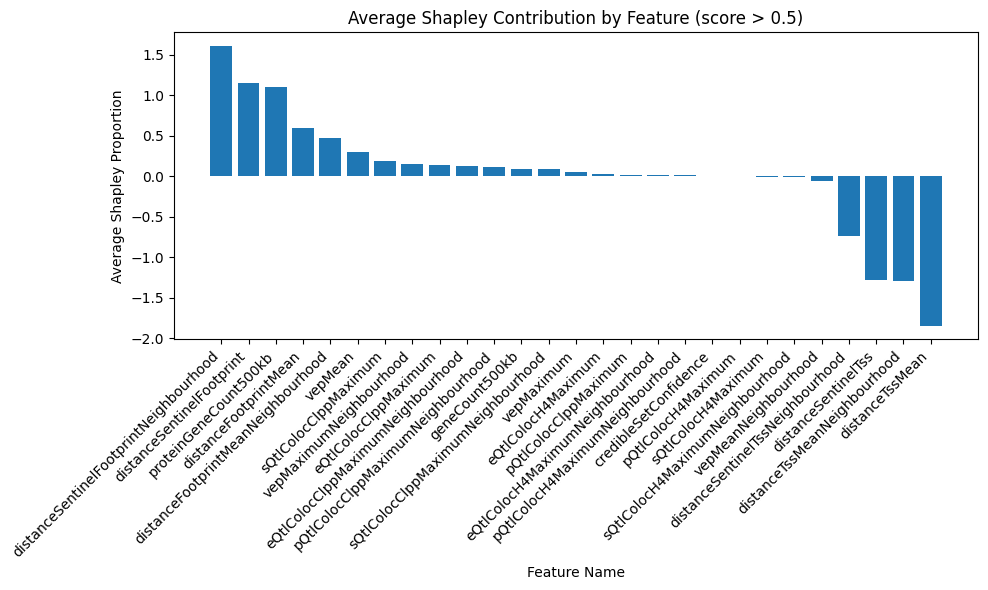

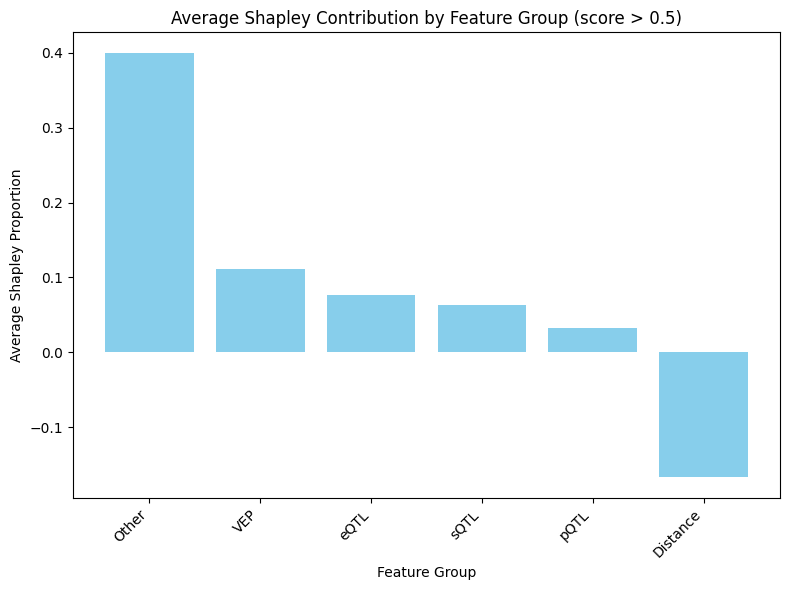

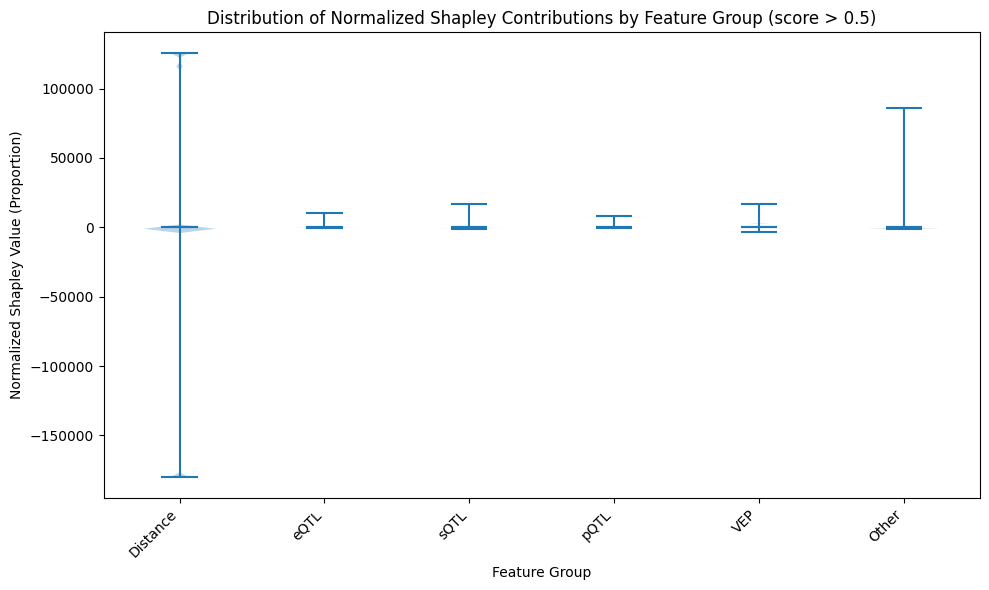

In [ ]:
import pyspark.sql.functions as f
import matplotlib.pyplot as plt

filtered_df = locus_to_gene_prediction_df

# -------------------------------
# For each row, compute total shapley value for its features.
# -------------------------------
# Use the aggregate function to sum the shapValue from the features array.

filtered_df = filtered_df.withColumn(
    "totalShap",
    f.expr("aggregate(features, cast(0.0 as double), (acc, x) -> acc + x.shapValue)")
)

# -------------------------------
# Normalize each feature's shapley value by computing its proportion.
# -------------------------------
# Create a new array column "norm_features", where each element is a struct including:
# - name: feature name
# - value: feature value (if needed)
# - shapValue: the original shapley value
# - shapProp: the normalized proportion, computed as shapValue divided by totalShap.

filtered_df = filtered_df.withColumn(
    "norm_features",
    f.expr("""
        transform(features, x -> named_struct(
            'name', x.name,
            'value', x.value,
            'shapValue', x.shapValue,
            'shapProp', x.shapValue / totalShap
        ))
    """)
)

# -------------------------------
# Explode the normalized features array so that each row corresponds to one feature.
# -------------------------------
exploded_df = filtered_df.withColumn("feature", f.explode("norm_features")).select("studyLocusId", "studyId", "geneId", "feature.*")
# Now the DataFrame has columns: name, value, shapValue, shapProp

# ===============================
# PLOT 1: Individual Feature Contributions
# ===============================
# Compute the average normalized shapley proportion (shapProp) per feature.
feature_props = exploded_df.groupBy("name").agg(f.avg("shapProp").alias("avg_prop")).orderBy("avg_prop", ascending=False)

# Convert to Pandas for plotting.
feature_props_pd = feature_props.toPandas()

# 6A. Plot the average shapley proportion by individual feature.
plt.figure(figsize=(10, 6))
plt.bar(feature_props_pd["name"], feature_props_pd["avg_prop"])
plt.xlabel("Feature Name")
plt.ylabel("Average Shapley Proportion")
plt.title("Average Shapley Contribution by Feature (score > 0.5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ===============================
# PLOT 2: Grouped Feature Contributions
# ===============================
#  Group the features into broader categories.
# Here we use simple regex matching on the feature name:
#   - If the name contains "distance" (case-insensitive), then group as "Distance"
#   - If it contains "eqtl" then "eQTL"
#   - If it contains "sqtl" then "sQTL"
#   - If it contains "pqtl" then "pQTL"
#   - If it contains "VEP" then "VEP"
#   - Otherwise, group as "Other"
exploded_df = exploded_df.withColumn(
    "feature_group",
    f.when(f.col("name").rlike("(?i)distance"), "Distance")
     .when(f.col("name").rlike("(?i)eqtl"), "eQTL")
     .when(f.col("name").rlike("(?i)sqtl"), "sQTL")
     .when(f.col("name").rlike("(?i)pqtl"), "pQTL")
     .when(f.col("name").rlike("(?i)VEP"), "VEP")
     .otherwise("Other")
)

# Compute the average shapley proportion grouped by the new feature group.
group_props = exploded_df.groupBy("feature_group").agg(f.avg("shapProp").alias("avg_prop")).orderBy("avg_prop", ascending=False)
group_props_pd = group_props.toPandas()

# Plot the average shapley proportion by feature group.
plt.figure(figsize=(8, 6))
plt.bar(group_props_pd["feature_group"], group_props_pd["avg_prop"], color="skyblue")
plt.xlabel("Feature Group")
plt.ylabel("Average Shapley Proportion")
plt.title("Average Shapley Contribution by Feature Group (score > 0.5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Convert the relevant columns ("feature_group" and "shapProp") to a Pandas DataFrame.
exploded_pd = exploded_df.select("feature_group", "shapProp").toPandas()

exploded_pd = exploded_pd.dropna(subset=["feature_group"])
desired_groups = ["Distance", "eQTL", "sQTL", "pQTL", "VEP", "Other"]

# Create a list with the shapProp values for each group.
group_data = []
group_labels = []
for grp in desired_groups:
    values = exploded_pd[exploded_pd["feature_group"] == grp]["shapProp"].tolist()
    if values:  # Only include the group if there are any values.
        group_data.append(values)
        group_labels.append(grp)

plt.figure(figsize=(10, 6))
parts = plt.violinplot(group_data, showmeans=True, showmedians=True, showextrema=True)
plt.xticks(np.arange(1, len(group_labels) + 1), group_labels, rotation=45, ha="right")
plt.xlabel("Feature Group")
plt.ylabel("Normalized Shapley Value (Proportion)")
plt.title("Distribution of Normalized Shapley Contributions by Feature Group (score > 0.5)")
plt.tight_layout()
plt.show()

In [ ]:
import pyspark.sql.functions as F

groups = ["Distance","eQTL","sQTL","pQTL","VEP","Other"]

# Sum shapProp per (studyLocusId, geneId, feature_group)
row_group_sums = (
    exploded_df
      .groupBy("studyLocusId","geneId","feature_group")
      .agg(F.sum("shapProp").alias("group_prop"))
)

# Pivot so each feature_group becomes its own column
pivot_df = (
    row_group_sums
      .groupBy("studyLocusId","geneId")
      .pivot("feature_group", groups)
      .sum("group_prop")
      .na.fill(0.0)  # anything missing becomes 0
)

# Binarize: 1 if that group_prop > 0.2, else 0
for grp in groups:
    pivot_df = pivot_df.withColumn(f"{grp}_bin", (F.col(grp) > 0.2).cast("int"))

# Show the binary table
binary_cols = [f"{grp}_bin" for grp in groups]
pivot_df.select("studyLocusId","geneId", *binary_cols).show(truncate=False)

# How many rows have 0, 1 or >1 decisive groups?
#    First add up the binaries into one column:
pivot_df = pivot_df.withColumn(
    "num_decisive",
    sum(F.col(c) for c in binary_cols)
)

pivot_df.groupBy("num_decisive").count().orderBy("num_decisive").show()

+--------------------------------+---------------+------------+--------+--------+--------+-------+---------+
|studyLocusId                    |geneId         |Distance_bin|eQTL_bin|sQTL_bin|pQTL_bin|VEP_bin|Other_bin|
+--------------------------------+---------------+------------+--------+--------+--------+-------+---------+
|0000570b33d89bb53bc41e5eab881405|ENSG00000134243|0           |0       |0       |1       |0      |0        |
|0000570b33d89bb53bc41e5eab881405|ENSG00000134222|1           |1       |1       |0       |0      |0        |
|0000570b33d89bb53bc41e5eab881405|ENSG00000143126|0           |0       |1       |1       |0      |0        |
|0002cd1632205979d9155eaf192c868c|ENSG00000112715|1           |0       |0       |0       |0      |0        |
|0003696a50893286fa2b9eaaf753b054|ENSG00000103569|1           |0       |0       |0       |0      |0        |
|00045308b9b2b684e80a6b0dc1fe65db|ENSG00000082438|1           |0       |0       |0       |1      |0        |
|000465684ba18d8d4e

+------------+------+
|num_decisive| count|
+------------+------+
|           1|220925|
|           2|467164|
|           3| 91992|
|           4|  3153|
|           5|   316|
+------------+------+



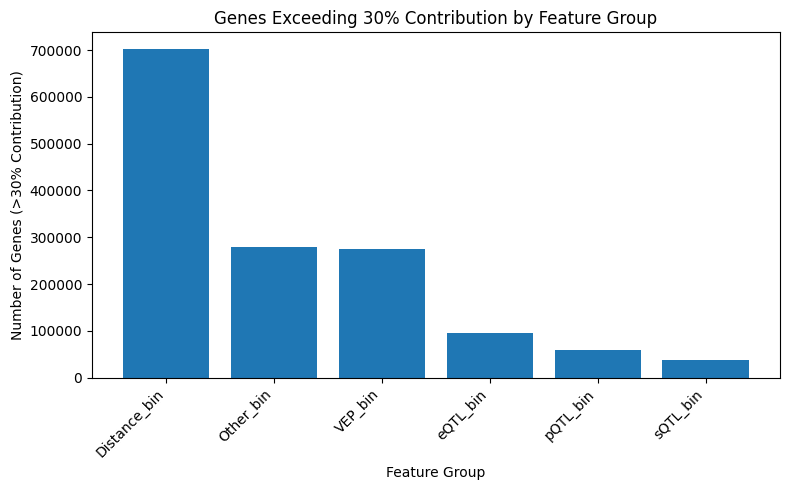

In [ ]:
import pyspark.sql.functions as f
import matplotlib.pyplot as plt

bin_cols = ["Distance_bin", "eQTL_bin", "sQTL_bin", "pQTL_bin", "VEP_bin", "Other_bin"]

# 1. Sum each bin column across all genes
area_counts = pivot_df.agg(
    *[f.sum(f.col(c)).alias(c) for c in bin_cols]
)

# 2. Convert to Pandas and reshape for plotting
area_counts_pd = area_counts.toPandas().melt(
    var_name="Feature Group",
    value_name="Gene Count"
).sort_values("Gene Count", ascending=False)

# 3. Plot
plt.figure(figsize=(8, 5))
plt.bar(area_counts_pd["Feature Group"], area_counts_pd["Gene Count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature Group")
plt.ylabel("Number of Genes (>30% Contribution)")
plt.title("Genes Exceeding 30% Contribution by Feature Group")
plt.tight_layout()
plt.show()

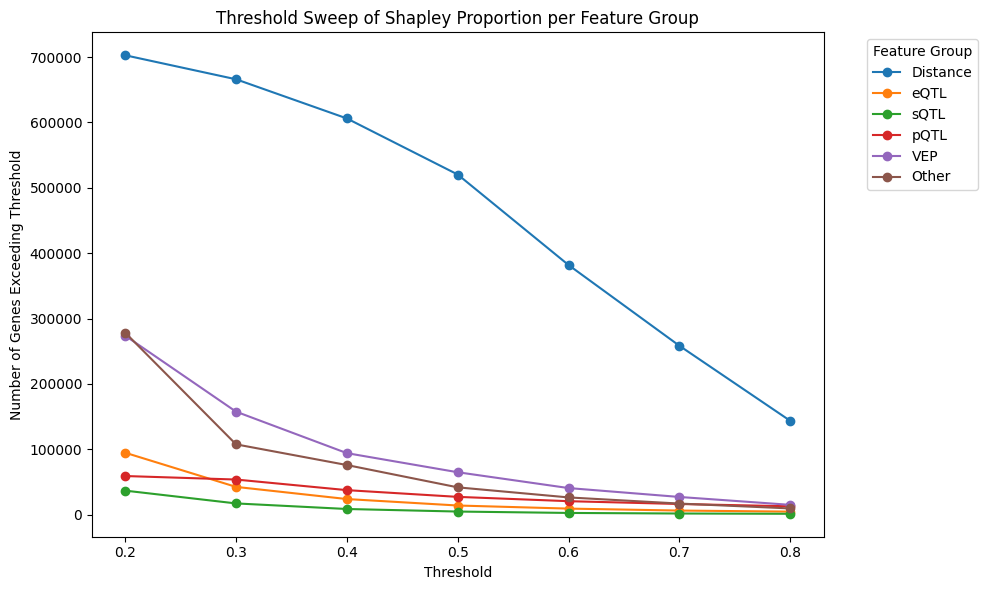

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pivot_pd = pivot_df.select("Distance", "eQTL", "sQTL", "pQTL", "VEP", "Other") \
                   .toPandas()

# Define groups and thresholds.
groups    = ["Distance", "eQTL", "sQTL", "pQTL", "VEP", "Other"]
thresholds = [i/10 for i in range(2,9)]   # 0.2 through 0.8

# Compute counts in Pandas
records = []
for thr in thresholds:
    counts = {"threshold": thr}
    for grp in groups:
        counts[grp] = int((pivot_pd[grp] > thr).sum())
    records.append(counts)

df_counts = pd.DataFrame(records).set_index("threshold")

# Plot each feature‐group’s curve.
plt.figure(figsize=(10,6))
for grp in groups:
    plt.plot(df_counts.index, df_counts[grp], marker='o', label=grp)

plt.xlabel("Threshold")
plt.ylabel("Number of Genes Exceeding Threshold")
plt.title("Threshold Sweep of Shapley Proportion per Feature Group")
plt.legend(title="Feature Group", bbox_to_anchor=(1.05,1), loc='upper left')
plt.xticks(thresholds)
plt.tight_layout()
plt.show()


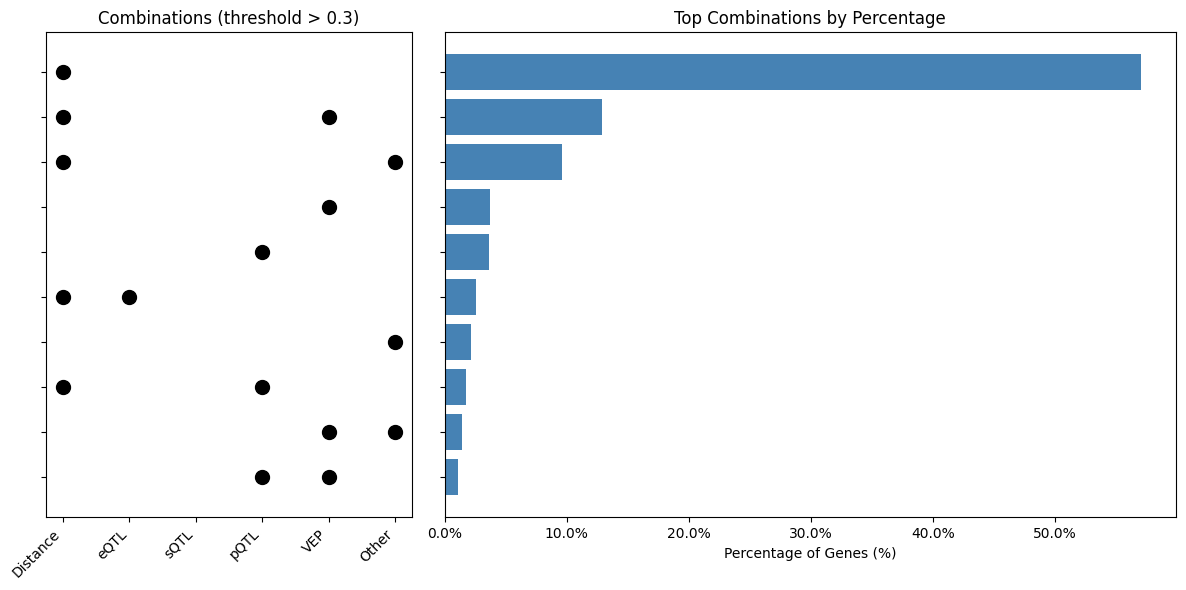

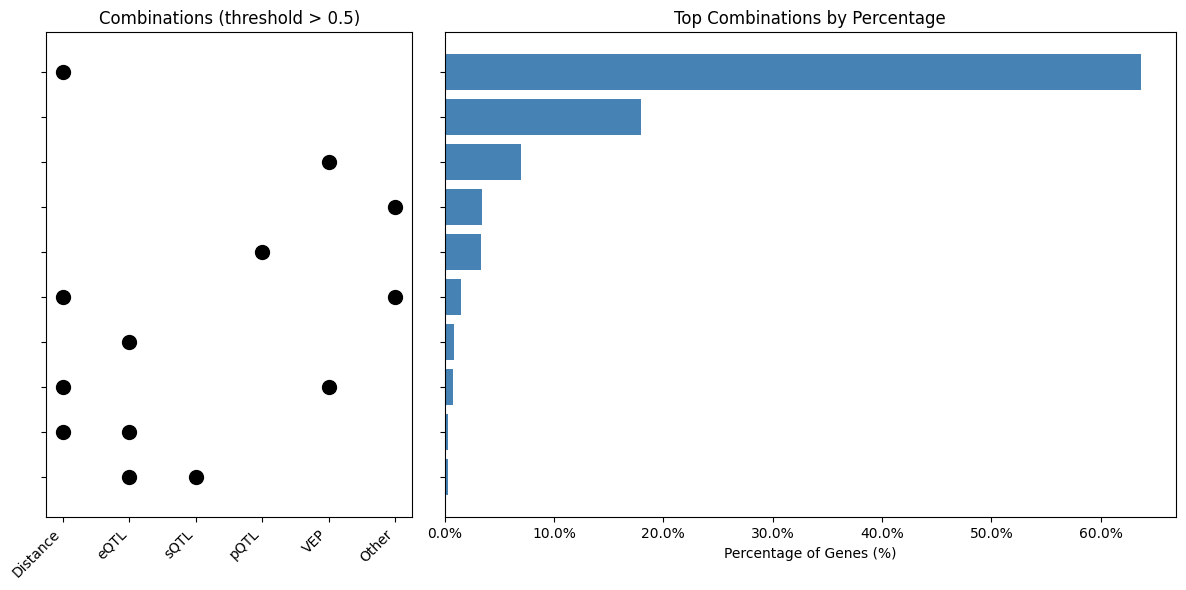

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

groups = ["Distance", "eQTL", "sQTL", "pQTL", "VEP", "Other"]
pivot_pd = pivot_df.select(groups).toPandas()

# Define the thresholds
thresholds = [0.3, 0.5]

# For each threshold, compute the binary flags, count combinations, convert to percentages, and plot
total = len(pivot_pd)
for thr in thresholds:
    # Binary indicator for each feature group
    binary_pd = (pivot_pd > thr).astype(int)
    
    # Count each unique combination of flags
    comb_counts = binary_pd.value_counts().reset_index(name='count')
    
    # Calculate percentages
    comb_counts['percent'] = comb_counts['count'] / total * 100
    
    # Take the top 10 most frequent combinations
    top_n = 10
    top_combs = comb_counts.head(top_n)
    
    # Extract matrix of flags and labels
    matrix = top_combs[groups].values
    percents = top_combs['percent'].values
    labels = [
        ";".join([grp for grp, flag in zip(groups, row) if flag]) or "None"
        for row in matrix
    ]
    
    # Create the dot‐matrix + percentage bar chart
    fig, (ax_dot, ax_bar) = plt.subplots(
        1, 2,
        gridspec_kw={'width_ratios': [1, 2]},
        figsize=(12, 6),
        sharey=True
    )
    
    # Dot matrix
    for i, row in enumerate(matrix):
        for j, flag in enumerate(row):
            if flag:
                ax_dot.scatter(j, i, s=100, color='black')
    ax_dot.set_xticks(range(len(groups)))
    ax_dot.set_xticklabels(groups, rotation=45, ha='right')
    ax_dot.set_yticks(range(len(labels)))
    ax_dot.set_yticklabels(labels)
    ax_dot.invert_yaxis()
    ax_dot.set_title(f"Combinations (threshold > {thr})")
    
    # Percentage bar chart
    ax_bar.barh(range(len(labels)), percents, color='steelblue')
    ax_bar.set_yticks(range(len(labels)))
    ax_bar.set_yticklabels([])
    ax_bar.set_xlabel("Percentage of Genes (%)")
    ax_bar.set_title("Top Combinations by Percentage")
    ax_bar.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:.1f}%"))
    
    plt.tight_layout()
    plt.show()